In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn import metrics
from sklearn.manifold import TSNE
import scipy.stats as st

import matplotlib.pyplot as plt

model_path = '/home/tstrebel/repos/umich-mads-capstone-project/tstrebe2/rnsa/models/rnsa-densenet.ckpt'
img_dir = '/home/tstrebel/assets/rnsa-pneumonia/train-images/'
img_features_path = '/home/tstrebel/assets/rnsa-pneumonia/rnsa-img-features.csv'
patient_data_path = '/home/tstrebel/repos/umich-mads-capstone-project/assets/rnsa-patient-details.csv'
all_labels_path = '/home/tstrebel/assets/rnsa-pneumonia/stage_2_train_labels.csv.zip'

In [2]:
df = pd.read_csv(img_features_path, index_col='index')

df_train_val = df[df.split.isin(['train', 'test'])]
df_test = df[df.split == 'test']

del df

_ = gc.collect()

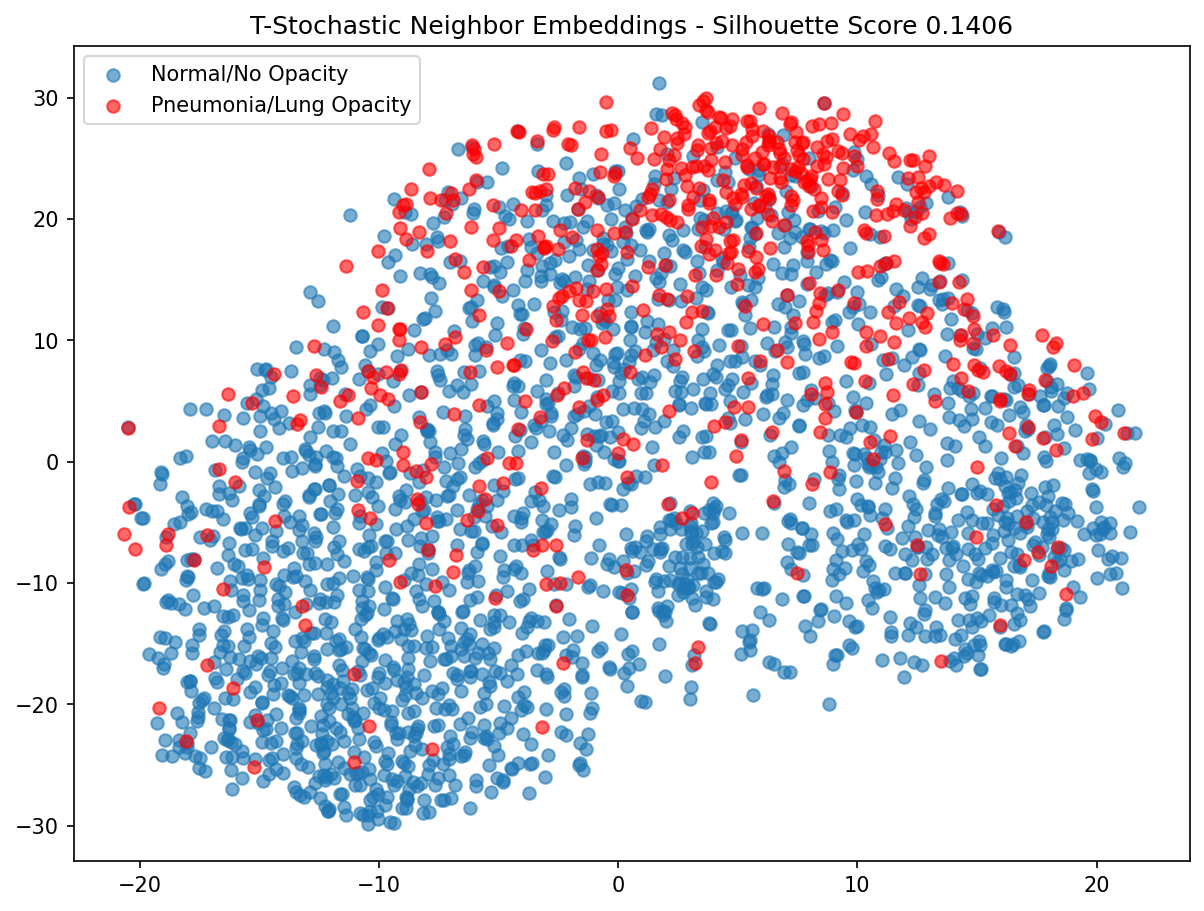

<Figure size 432x288 with 0 Axes>

In [24]:
targets = df_test.iloc[:, -2]

tsne = TSNE(n_components=2, 
            perplexity=50,
            early_exaggeration=50, 
            learning_rate=10, 
            n_jobs=-1
           ).fit_transform(df_test.iloc[:, 1:-2])

ix_0 = np.where(targets == 0)[0]
ix_1 = np.where(targets == 1)[0]

sil_score = metrics.silhouette_score(tsne, targets)

figsize = np.array([6.4, 4.8]) * 1.5

_ = plt.figure(dpi=150, figsize=figsize)
plt.scatter(tsne[ix_0, 0], tsne[ix_0, 1], alpha=.6, label='Normal/No Opacity')
plt.scatter(tsne[ix_1, 0], tsne[ix_1, 1], alpha=.6, color='red', label='Pneumonia/Lung Opacity')
plt.title('T-Stochastic Neighbor Embeddings - Silhouette Score {:.4f}'.format(sil_score))
plt.legend()
plt.show()
plt.tight_layout()
plt.show()

In [2]:
THRESH = 0.3948
df_patients = pd.read_csv(patient_data_path, index_col='index')
df_patients['densenet_prediction'] = (df_patients['densenet_predict_proba'] >= THRESH).astype(int)
df_patients['age_group'] = pd.cut(df_patients.patient_age, 
                                  [0, 1, 5, 12, 18, 44, 64, 79, np.inf], 
                                  labels=['Infant 1 year-old', 'preschool (2-5)', 'Child (6-12)', 'Adolescent (13-18)', 'Adult (19-44)', 'Middle age (45-64)', 'Aged (65-79)', 'Aged 80+']
                                 )
df_patients['view_position'] = df_patients['view_position'].map({'AP':'Anterior/Posterior', 'PA':'Posterior/Anterior'})
df_patients

,patient_id,patient_age,patient_sex,view_position,class,target,split,densenet_predict_proba,densenet_prediction,age_group
index,,,,,,,,,,
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,Posterior/Anterior,No Lung Opacity / Not Normal,0,train,0.028890,0,Middle age (45-64)
1,000924cf-0f8d-42bd-9158-1af53881a557,19,F,Anterior/Posterior,Normal,0,train,0.002505,0,Adult (19-44)
2,000db696-cf54-4385-b10b-6b16fbb3f985,25,F,Anterior/Posterior,Lung Opacity,1,train,0.226189,0,Adult (19-44)
3,000fe35a-2649-43d4-b027-e67796d412e0,40,M,Anterior/Posterior,Lung Opacity,1,train,0.967209,1,Adult (19-44)
4,001031d9-f904-4a23-b3e5-2c088acd19c6,57,M,Posterior/Anterior,Lung Opacity,1,train,0.067874,0,Middle age (45-64)
...,...,...,...,...,...,...,...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,46,M,Anterior/Posterior,Lung Opacity,1,train,0.931316,1,Middle age (45-64)
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,31,M,Posterior/Anterior,Normal,0,val,0.000546,0,Adult (19-44)
26681,fffc95b5-605b-4226-80ab-62caec682b22,30,F,Anterior/Posterior,No Lung Opacity / Not Normal,0,test,0.692472,1,Adult (19-44)


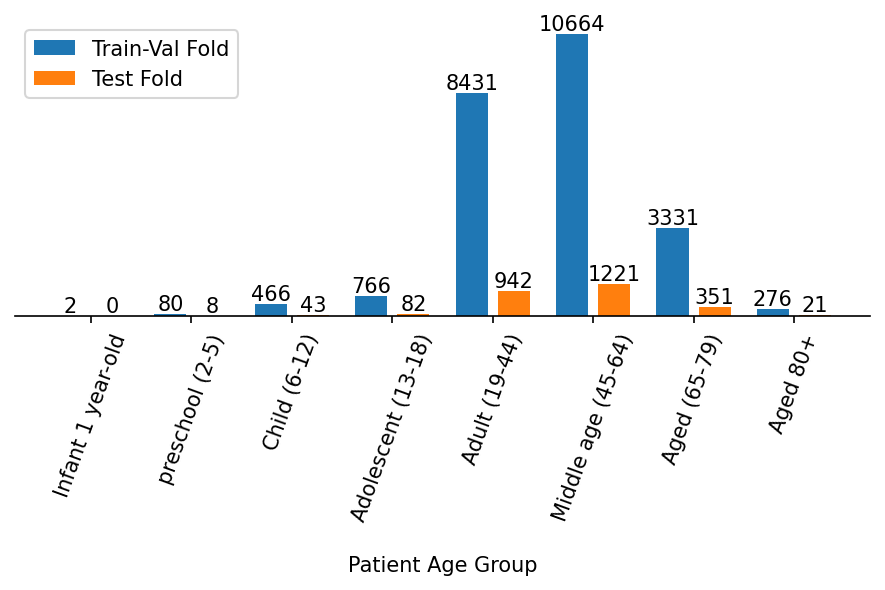

In [3]:
def plot_age_groups(data):
    train_val_bins = data[data.split.isin(['train', 'val'])].age_group.value_counts().sort_index()
    test_bins = data[data.split.isin(['test'])].age_group.value_counts().sort_index()

    fig = plt.figure(dpi=150)
    ax = plt.gca()
    
    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Patient Age Group', labelpad=15)
    
    width = .32
    
    for label, bins, delta in (('Train-Val Fold', train_val_bins, -(width+.1)), ('Test Fold', test_bins, width+.1)):
        labels = bins.index.astype(str).to_list()
        x = np.arange(len(labels))
        y = bins.values

        p1 = ax.bar(x + delta/2, y, width=width, label=label)
        ax.bar_label(p1)

    ax.set_xticks(x, labels, rotation=70)

    plt.legend(loc='upper left')
    # plt.xticks()
    fig.tight_layout()

    plt.show()
    
plot_age_groups(df_patients)

In [4]:
# Radiographic view defined terms: AP = Anterior/Posterior PA = Posterior/Anterior
pd.set_option("display.precision", 3)

def get_95_ci(data):
    mean = np.mean(data)
    return mean, *st.t.interval(alpha=0.95, df=len(data)-1, loc=mean, scale=st.sem(data)) 

def get_statistics(data, split=None):
    data = data.copy()
    
    age = (data[['patient_age', 'class']]
     .groupby('class')
     .apply(lambda grp: get_95_ci(grp.patient_age))
     .to_frame()
     .apply(lambda x: {'Mean':x[0][0], 'Low':x[0][1], 'High':x[0][2]}, axis=1, result_type='expand')
    )
    data.target = data.target.map({0:'Negative', 1:'Positive'})
    
    target = (data
           [['target', 'class']]
           .pivot_table(index='class', columns='target', values='target', aggfunc=len)).fillna(0).astype(int)

    sex = (data
           [['patient_sex', 'class']]
           .pivot_table(index='class', columns='patient_sex', values='patient_sex', aggfunc=len))
    
    view_position = (data
           [['view_position', 'class']]
           .pivot_table(index='class', columns='view_position', values='view_position', aggfunc=len))
    
    result = target.join([view_position, sex, age])
    
    arrs = [['Class', 'Class', 'View Position', 'View Position', 'Sex', 'Sex', 'Age', 'Age 95% CI', 'Age 95% CI'], result.columns.tolist()]
    result.columns = pd.MultiIndex.from_arrays(arrs)
    return pd.concat([result], keys=[split], names=[''])

pd.concat([
    get_statistics(df_patients[df_patients['split'].isin(['train', 'val'])], split='Train-Val'),
    get_statistics(df_patients[df_patients['split'] == 'test'], split='Test')
])

Class               View Position  \
                                       Negative Positive Anterior/Posterior   
          class                                                               
Train-Val Lung Opacity                        0     5411               4206   
          No Lung Opacity / Not Normal    10666        0               5276   
          Normal                           7939        0               1449   
Test      Lung Opacity                        0      601                458   
          No Lung Opacity / Not Normal     1155        0                596   
          Normal                            912        0                188   

                                                            Sex           Age  \
                                       Posterior/Anterior     F     M    Mean   
          class                                                                 
Train-Val Lung Opacity                               1205  2260  3151  45.557   
          No Lung Opacity / Not Normal               5390  4609  6057  49.396   
          Normal                                     6490  3501  4438  44.896   
Test      Lung Opacity                                143   242   359  45.814   
          No Lung Opacity / Not Normal                559   502   653  48.754   
          Normal                                      724   404   508  45.297   

                                       Age 95% CI          
                                              Low    High  
          class                                            
Train-Val Lung Opacity                     45.091  46.022  
          No Lung Opacity / Not Normal     49.083  49.709  
          Normal                           44.534  45.258  
Test      Lung Opacity                     44.410  47.217  
          No Lung Opacity / Not Normal     47.809  49.700  
          Normal                           44.269  46.326

In [12]:
df_test = df_patients[df_patients['split'] == 'test']

def get_metrics_by_group(data, group):
    n = data[group].value_counts().rename('n-patients')
    n_neg = data[data.target == 0][group].value_counts().rename('n-negative')
    n_pos = data[data.target == 1][group].value_counts().rename('n-positive')
    n = n.to_frame().join([n_neg, n_pos])
    
    results = []
    
    def get_average_precision_score(grp):
        if len(grp) > 0:
            return metrics.average_precision_score(grp['target'], grp['densenet_predict_proba'])
        else:
            return 0
        
    avg_precision = (data.groupby(group)
              .apply(get_average_precision_score).rename('Average Precision'))
    results.append(avg_precision)
    
    def get_metrics(grp, metric_fn):
        if len(grp) > 0:
            return metric_fn(grp['target'], grp['densenet_prediction'])
        else:
            return 0
    
    for metric_name, metric_fn in [('Precision', metrics.precision_score), 
                                   ('Recall', metrics.recall_score), 
                                   ('F1', metrics.f1_score), 
                                   ('Accuracy', metrics.accuracy_score)]:
        metric_result = (data.groupby(group)
                  .apply(get_metrics, metric_fn)).rename(metric_name)
        results.append(metric_result)
    
    return n.join(results).sort_index()

get_metrics_by_group(df_test, group='patient_sex')

,n-patients,n-negative,n-positive,Average Precision,Precision,Recall,F1,Accuracy
F,1148,906,242,0.664,0.594,0.624,0.609,0.831
M,1520,1161,359,0.648,0.622,0.591,0.606,0.818


In [13]:
get_metrics_by_group(df_test, group='view_position')

,n-patients,n-negative,n-positive,Average Precision,Precision,Recall,F1,Accuracy
Anterior/Posterior,1242,784,458,0.704,0.626,0.694,0.658,0.734
Posterior/Anterior,1426,1283,143,0.443,0.517,0.315,0.391,0.902


In [14]:
get_metrics_by_group(df_test, group='age_group')

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,n-patients,n-negative,n-positive,Average Precision,Precision,Recall,F1,Accuracy
Infant 1 year-old,0,0,0,0.000,0.000,0.000,0.000,0.000
preschool (2-5),8,6,2,0.833,0.000,0.000,0.000,0.750
Child (6-12),43,28,15,0.876,0.778,0.933,0.848,0.884
Adolescent (13-18),82,55,27,0.738,0.704,0.704,0.704,0.805
Adult (19-44),942,730,212,0.668,0.604,0.632,0.618,0.824
Middle age (45-64),1221,962,259,0.663,0.621,0.595,0.607,0.837
Aged (65-79),351,273,78,0.510,0.521,0.487,0.503,0.786
Aged 80+,21,13,8,0.737,0.571,0.500,0.533,0.667


In [45]:
import visuals
import models
import torch
import data

df_all = pd.read_csv(all_labels_path).rename({'patientId':'patient_id', 'Target':'target'}, axis=1)
df_all.head()

,patient_id,x,y,width,height,target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.Densenet121GradCam()
state_dict = torch.load(model_path, map_location=device)['state_dict']
_ = model.load_state_dict(state_dict)
model = model.to(device)

dataset = data.get_dataset(img_dir, df_test)

In [23]:
# import torchvision

# torchvision.models.resnet.ResNet??

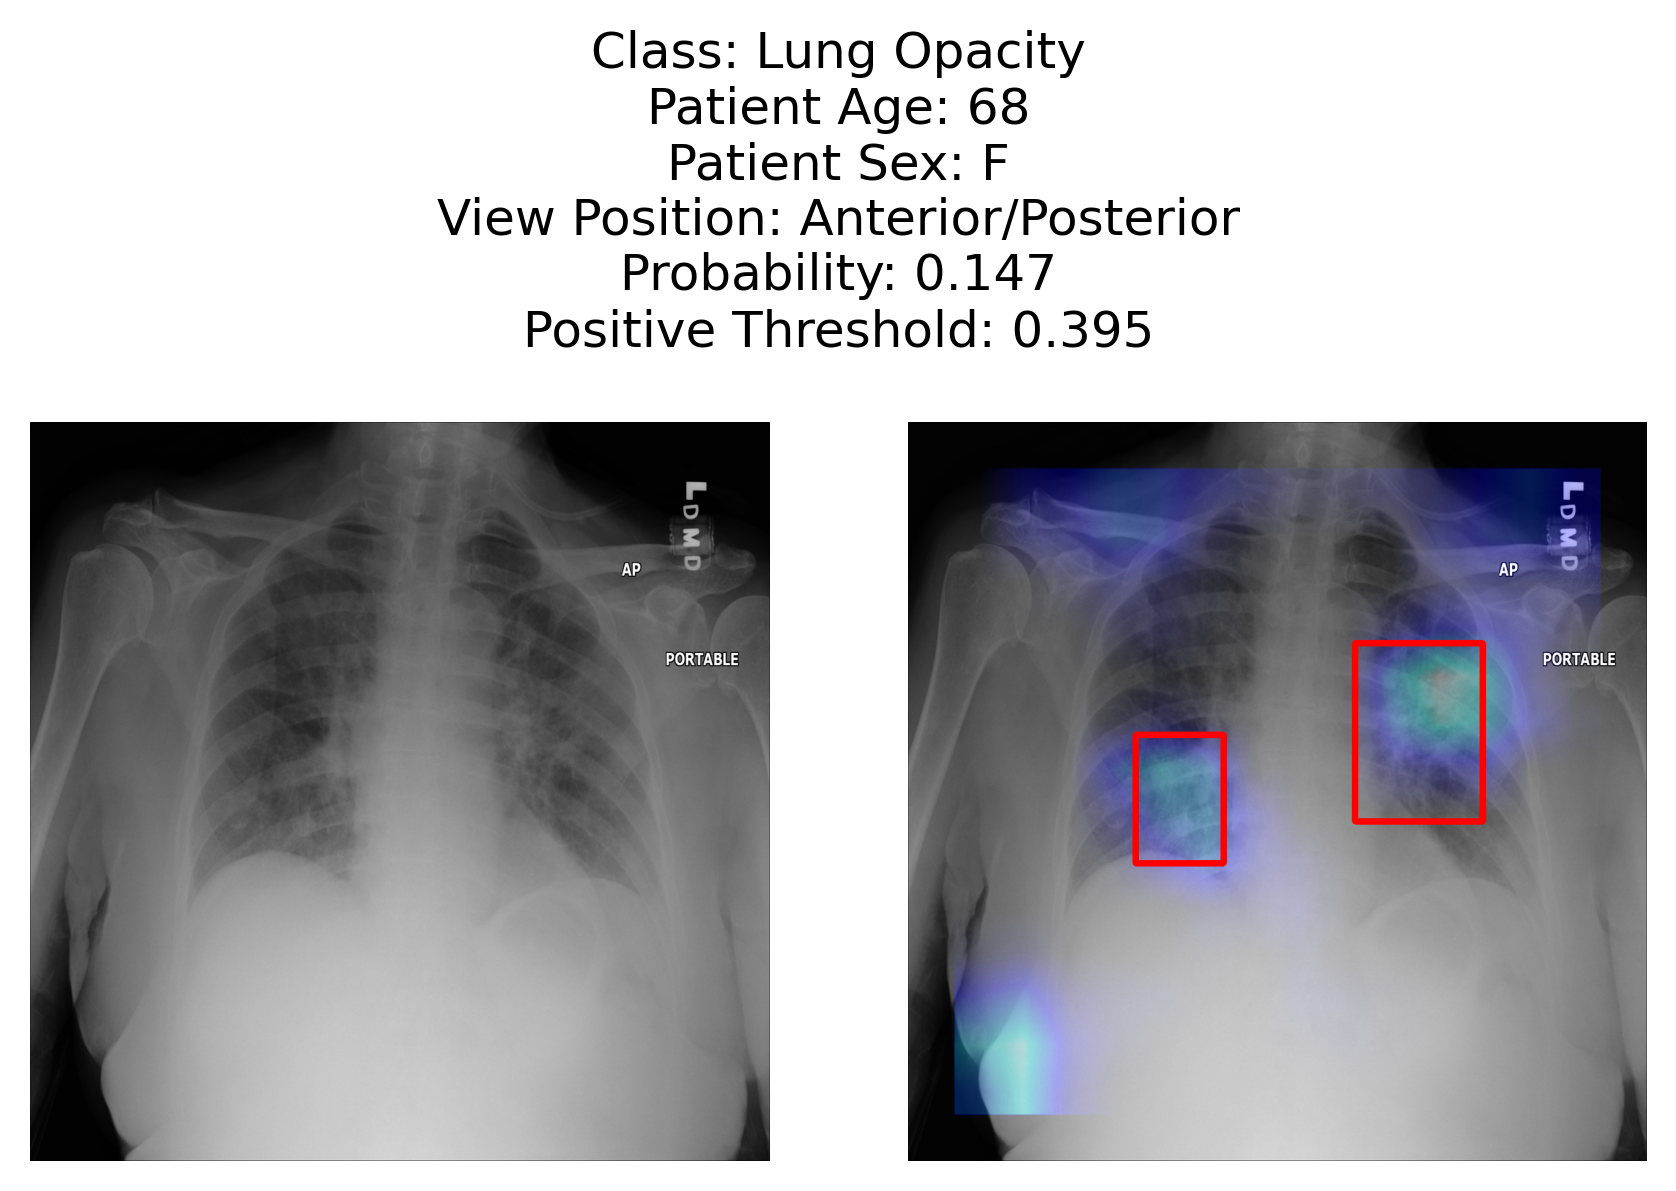

In [123]:
patient = df_test[(df_test.patient_age >= 0) & (df_test.target == 1) & (df_test.densenet_prediction == 0)].sample(1).iloc[0]
threshold=0.3948
idx = np.where(df_test.patient_id==patient.patient_id)[0][0]
inputs, target = dataset[idx]

inputs = inputs.unsqueeze(dim=0).to(device)
target = target.to(device)
    
fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=300)
visuals.show_gradcam(img_dir, model, patient, inputs, target, df_all, ax1, ax2, threshold=threshold)

ax1.axis('off')
ax2.axis('off')
fig.suptitle('Class: {}\nPatient Age: {}\nPatient Sex: {}\nView Position: {}\nProbability: {:.3f}\nPositive Threshold: {:.3f}'
             .format(patient['class'], 
                     patient.patient_age, 
                     patient.patient_sex,
                     patient.view_position,
                     patient.densenet_predict_proba,
                     THRESH,))
fig.tight_layout()
plt.show()